# Recursion RxRx2 Data Exploration
#### Chris Turori

Exploring the RxRx2 embedding dataset provided by Recursion. Using PCA and t-SNE visualizations as a tool for exploring potential variability within the RxRx2 embedding dataset. The goal is to assess variability between experiments, plates, wells and image sites. Such analysis can be useful in understanding the limits of the dataset.

In [1]:
# import packages
import os
import shutil
import time
import numpy as np
import pandas as pd
import matplotlib as plt
import zipfile
from urllib.request import urlopen
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

<font size="4">Download metadata and embeddings from link provided by RxRx.AI website</font>

In [2]:
# metadata url
metaDataUrl = "https://storage.googleapis.com/rxrx/rxrx2/rxrx2-metadata.zip"

# download data
url = urlopen(metaDataUrl)
output = open('metadata.zip', 'wb')
output.write(url.read())
output.close()

# unzip file
with zipfile.ZipFile("metadata.zip","r") as zip_ref:
    zip_ref.extractall(os.getcwd())

# clean up after yo self
os.replace('rxrx2/metadata.csv', 'metadata.csv') # move csv to project root
os.remove('metadata.zip')                        # remove zip
shutil.rmtree('rxrx2')                           # remove unzipped folder

In [3]:
# embeddings url
embeddingsUrl = "https://storage.googleapis.com/rxrx/rxrx2/rxrx2-dl-embeddings.zip"

# download data
url = urlopen(embeddingsUrl)
output = open('rxrx2-dl-embeddings.zip', 'wb')
output.write(url.read())
output.close()

# unzip file
with zipfile.ZipFile("rxrx2-dl-embeddings.zip","r") as zip_ref:
    zip_ref.extractall(os.getcwd())

# just cleaning up after myself...
os.remove('rxrx2-dl-embeddings.zip') # remove zip file

<font size="4">Load datasets into project</font>

In [4]:
# load metadata csv into dataframe
df = pd.read_csv('metadata.csv')
print('Metadata loaded!')

Metadata loaded!


In [5]:
# load embeddings csv into dataframe
df2 = pd.read_csv('rxrx2-dl-embeddings.csv')
print('Embedding data loaded!')

Embedding data loaded!


In [6]:
# review metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131953 entries, 0 to 131952
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   site_id         131953 non-null  object 
 1   well_id         131953 non-null  object 
 2   cell_type       131953 non-null  object 
 3   experiment      131953 non-null  object 
 4   plate           131953 non-null  int64  
 5   well            131953 non-null  object 
 6   site            131953 non-null  int64  
 7   treatment       131953 non-null  object 
 8   treatment_conc  124374 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 9.1+ MB


In [7]:
# review feature data
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131953 entries, 0 to 131952
Columns: 129 entries, site_id to feature_127
dtypes: float64(128), object(1)
memory usage: 129.9+ MB


<font size="4">Join metadata and embeddings</font>

In [8]:
# combine metadata and embeddings
# inner join on site id
mergedDataFrame = pd.merge(df, df2, how='left',  on=['site_id', 'site_id'])

In [9]:
# review merged dataframe 
mergedDataFrame.info()
mergedDataFrame.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131953 entries, 0 to 131952
Columns: 137 entries, site_id to feature_127
dtypes: float64(129), int64(2), object(6)
memory usage: 138.9+ MB


,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc,feature_0,...,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127
0,HUVEC-1_1_AA03_1,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,1,Sonic-Hedgehog,0.1,-0.316918,...,0.044025,0.136659,-2.087172,2.860377,0.231014,0.338580,-0.504502,-1.992612,-1.328181,0.587981
1,HUVEC-1_1_AA03_2,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,2,Sonic-Hedgehog,0.1,0.914670,...,0.508053,0.828908,-2.586799,1.503782,-0.482412,0.894832,-1.406880,-1.567457,-1.237937,0.967158
2,HUVEC-1_1_AA03_3,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,3,Sonic-Hedgehog,0.1,0.384831,...,-1.566359,0.798682,-2.241158,2.297683,0.340067,-0.032073,-0.765850,-1.615617,-2.184443,0.673777
3,HUVEC-1_1_AA03_4,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,4,Sonic-Hedgehog,0.1,0.733473,...,-0.313790,0.446107,-2.883605,1.824921,-0.252444,-0.125901,-1.181341,-1.027408,-1.475612,0.640989
4,HUVEC-1_1_AA04_1,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,GDF-1,0.1,0.512833,...,-0.584362,-0.101393,-2.937795,2.197699,-0.537146,0.019088,-0.495586,-1.710877,-2.491404,0.924014


<font size="4">Summarize metadata:</font>

In [10]:
# unique values of metadata groups
experiments = mergedDataFrame['experiment'].unique()
cellTypes = mergedDataFrame['cell_type'].unique()
treatments = mergedDataFrame['treatment'].unique()
plates = mergedDataFrame['plate'].unique()

# print counts 
print('# experiments: \t', experiments.size, '\t(', ', '.join(experiments), ')')
print('# cell types: \t', cellTypes.size,    '\t(', ', '.join(cellTypes), ')')
print('# plates: \t', plates.size,           '\t(', ', '.join(plates.astype(str)), ')')
print('# treatments: \t', treatments.size,   '\t(', ', '.join(treatments[0:4]), ', ...)')
mergedDataFrame.head()

# experiments: 	 2 	( HUVEC-1, HUVEC-2 )
# cell types: 	 1 	( HUVEC )
# plates: 	 12 	( 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 )
# treatments: 	 434 	( Sonic-Hedgehog, GDF-1, CCL14a, GDF-8 , ...)


,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc,feature_0,...,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127
0,HUVEC-1_1_AA03_1,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,1,Sonic-Hedgehog,0.1,-0.316918,...,0.044025,0.136659,-2.087172,2.860377,0.231014,0.338580,-0.504502,-1.992612,-1.328181,0.587981
1,HUVEC-1_1_AA03_2,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,2,Sonic-Hedgehog,0.1,0.914670,...,0.508053,0.828908,-2.586799,1.503782,-0.482412,0.894832,-1.406880,-1.567457,-1.237937,0.967158
2,HUVEC-1_1_AA03_3,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,3,Sonic-Hedgehog,0.1,0.384831,...,-1.566359,0.798682,-2.241158,2.297683,0.340067,-0.032073,-0.765850,-1.615617,-2.184443,0.673777
3,HUVEC-1_1_AA03_4,HUVEC-1_1_AA03,HUVEC,HUVEC-1,1,AA03,4,Sonic-Hedgehog,0.1,0.733473,...,-0.313790,0.446107,-2.883605,1.824921,-0.252444,-0.125901,-1.181341,-1.027408,-1.475612,0.640989
4,HUVEC-1_1_AA04_1,HUVEC-1_1_AA04,HUVEC,HUVEC-1,1,AA04,1,GDF-1,0.1,0.512833,...,-0.584362,-0.101393,-2.937795,2.197699,-0.537146,0.019088,-0.495586,-1.710877,-2.491404,0.924014


# Principal Component Analysis
Visualize features in PCA plot to reduce dimensionality of data. Filter out treatments and focus on EMPTY wells to see if there are any groupings betweeen experiments, plates, wells, or image sites.

In [11]:
# filter data 
filteredDataFrame = mergedDataFrame[mergedDataFrame['treatment'] == 'EMPTY']

# split features from metadata
liMetadata = filteredDataFrame.columns.str.find('feature') == -1
ixMetadata = list(filter(lambda i: liMetadata[i].any(), range(len(liMetadata)))) 
features = filteredDataFrame.drop(filteredDataFrame.columns[ixMetadata], axis=1)

liFeatures = filteredDataFrame.columns.str.find('feature') == 0
ixFeatures = list(filter(lambda i: liFeatures[i].any(), range(len(liFeatures)))) 
metadata = filteredDataFrame.drop(filteredDataFrame.columns[ixFeatures], axis=1)

print('Original: \t', mergedDataFrame.shape)
print('Metadata: \t', metadata.shape)
print('Features: \t', features.shape)
#features.head()

Original: 	 (131953, 137)
Metadata: 	 (7579, 9)
Features: 	 (7579, 128)


<font size="4">Summarize filtered metadata:</font>

In [12]:
# unique groups of metadata
experiments = metadata['experiment'].unique()
cellTypes = metadata['cell_type'].unique()
treatments = metadata['treatment'].unique()
plates = metadata['plate'].unique()

# print counts 
print('# experiments: \t', experiments.size, '\t(', ', '.join(experiments), ')')
print('# cell types: \t', cellTypes.size,    '\t(', ', '.join(cellTypes), ')')
print('# plates: \t', plates.size,           '\t(', ', '.join(plates.astype(str)), ')')
print('# treatments: \t', treatments.size,   '\t(', ', '.join(treatments), ')')

# experiments: 	 2 	( HUVEC-1, HUVEC-2 )
# cell types: 	 1 	( HUVEC )
# plates: 	 12 	( 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 )
# treatments: 	 1 	( EMPTY )


<font size="4">Train PCA model with filtered feature data</font>

In [13]:
# create PCA model
pca = PCA(n_components = 3)

# fit PCA model
pca_projections = pca.fit_transform(features)

# format projection data
explainedVariance = pca.explained_variance_ratio_
explainedVariance = [ '%.2f' % component for component in explainedVariance ]
projections = metadata.copy()
projections['PC-1'] = pca_projections[:, 0]
projections['PC-2'] = pca_projections[:, 1]
projections['PC-3'] = pca_projections[:, 2]

# print principal component info
print('Explained variation per principal component: {}'.format(explainedVariance))
print('Features: \t{}'.format(features.shape))
print('Projections: \t{}'.format(pca_projections.shape))
projections.head()

Explained variation per principal component: ['0.33', '0.10', '0.07']
Features: 	(7579, 128)
Projections: 	(7579, 3)


,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc,PC-1,PC-2,PC-3
128,HUVEC-1_1_AA35_1,HUVEC-1_1_AA35,HUVEC,HUVEC-1,1,AA35,1,EMPTY,NaN,-7.084023,-0.261007,-1.238076
129,HUVEC-1_1_AA35_2,HUVEC-1_1_AA35,HUVEC,HUVEC-1,1,AA35,2,EMPTY,NaN,-6.692954,0.574957,0.082436
130,HUVEC-1_1_AA35_3,HUVEC-1_1_AA35,HUVEC,HUVEC-1,1,AA35,3,EMPTY,NaN,-5.999190,-2.168163,-0.734773
131,HUVEC-1_1_AA35_4,HUVEC-1_1_AA35,HUVEC,HUVEC-1,1,AA35,4,EMPTY,NaN,-5.762953,0.283107,-0.439580
156,HUVEC-1_1_AA42_1,HUVEC-1_1_AA42,HUVEC,HUVEC-1,1,AA42,1,EMPTY,NaN,-5.759658,-1.212930,-1.515471


<font size="4">Visualize principal components in 2D and 3D plots, colored by experiment</font>

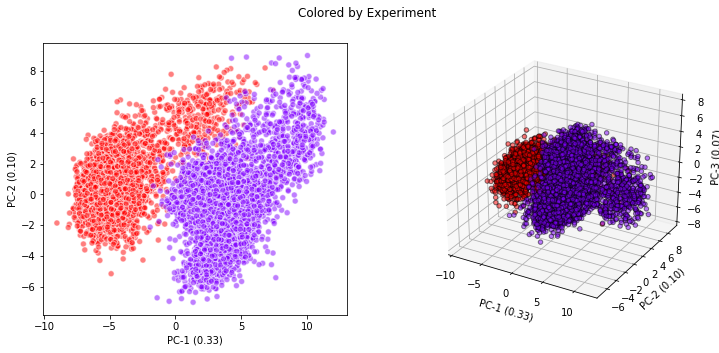

In [14]:
# create color indexing for experiments
experiments = metadata['experiment']
keys = experiments.unique()
values = range(len(experiments))
replacementValues = {keys[i]: values[i] for i in range(len(keys))} 
experimentIndex = experiments.replace(replacementValues)

# setup figure
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Colored by Experiment')

# create 2D PC plot
ax = fig.add_subplot(1, 2, 1)
ax.scatter(projections['PC-1'], projections['PC-2'],
            c = experimentIndex, edgecolor='white', alpha=0.5,
            cmap = plt.cm.get_cmap('rainbow_r', 10))
ax.set_xlabel('PC-1 ({})'.format(explainedVariance[0]))
ax.set_ylabel('PC-2 ({})'.format(explainedVariance[1]))

# create 3D PC plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(projections['PC-1'], projections['PC-2'], projections['PC-3'],
           c = experimentIndex, edgecolor='none', alpha=0.5,
           cmap = plt.cm.get_cmap('rainbow_r', 10))
ax.set_xlabel('PC-1 ({})'.format(explainedVariance[0]))
ax.set_ylabel('PC-2 ({})'.format(explainedVariance[1]))
ax.set_zlabel('PC-3 ({})'.format(explainedVariance[2]))

plt.show()

There appears to be a visual clustering by experiment, implying a potential batch effect between empty wells from the two experiments.

<font size="4">Visualize principal components in 2D and 3D plots, colored by plate number</font>

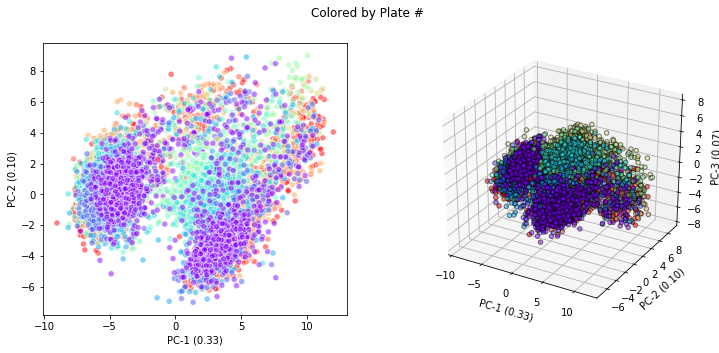

In [15]:
# create color indexing for plates
plates = metadata['plate']
keys = plates.unique()
values = range(len(plates))
replacementValues = {keys[i]: values[i] for i in range(len(keys))} 
plateIndex = plates.replace(replacementValues)

# setup figure
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Colored by Plate #')

# create 2D PC plot
ax = fig.add_subplot(1, 2, 1)
ax.scatter(projections['PC-1'], projections['PC-2'],
            c = plateIndex, edgecolor='white', alpha=0.5,
            cmap = plt.cm.get_cmap('rainbow_r', 10))
ax.set_xlabel('PC-1 ({})'.format(explainedVariance[0]))
ax.set_ylabel('PC-2 ({})'.format(explainedVariance[1]))

# create 3D PC plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(projections['PC-1'], projections['PC-2'], projections['PC-3'],
           c = plateIndex, edgecolor='none', alpha=0.5,
           cmap = plt.cm.get_cmap('rainbow_r', 10))
ax.set_xlabel('PC-1 ({})'.format(explainedVariance[0]))
ax.set_ylabel('PC-2 ({})'.format(explainedVariance[1]))
ax.set_zlabel('PC-3 ({})'.format(explainedVariance[2]))

plt.show()

<font size="4">Visualize principal components in 2D and 3D plots, colored by wells.</font>

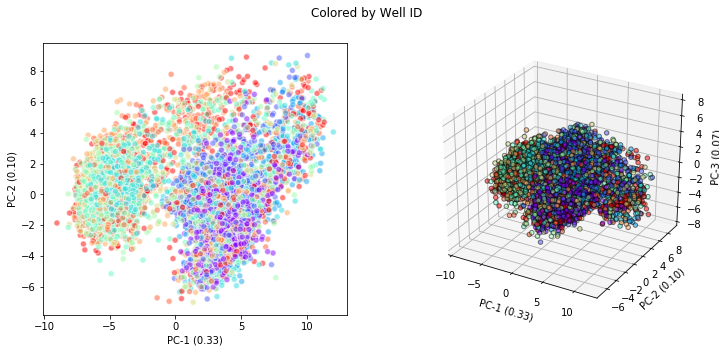

In [16]:
# create color indexing for wells
wells = metadata['well']
keys = wells.unique()
values = range(len(wells))
replacementValues = {keys[i]: values[i] for i in range(len(keys))} 
wellIndexs = wells.replace(replacementValues)

# setup figure
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Colored by Well ID')

# create 2D PC plot
ax = fig.add_subplot(1, 2, 1)
ax.scatter(projections['PC-1'], projections['PC-2'],
            c = wellIndexs, edgecolor='white', alpha=0.5,
            cmap = plt.cm.get_cmap('rainbow_r', 10))
ax.set_xlabel('PC-1 ({})'.format(explainedVariance[0]))
ax.set_ylabel('PC-2 ({})'.format(explainedVariance[1]))

# create 3D PC plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(projections['PC-1'], projections['PC-2'], projections['PC-3'],
           c = wellIndexs, edgecolor='none', alpha=0.5,
           cmap = plt.cm.get_cmap('rainbow_r', 10))
ax.set_xlabel('PC-1 ({})'.format(explainedVariance[0]))
ax.set_ylabel('PC-2 ({})'.format(explainedVariance[1]))
ax.set_zlabel('PC-3 ({})'.format(explainedVariance[2]))

plt.show()

Unclear clustering by visual inspection: there appears to be seperation of lighter and darker data points on the 2D plot, however the data points in the 3D plot seem to be distributed more evenly. 

<font size="4">Visualize principal components in 2D and 3D plots, colored by site number.</font>

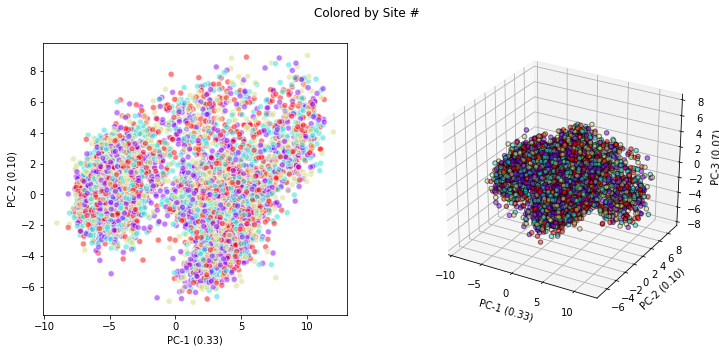

In [17]:
# setup figure
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Colored by Site #')

# create 2D PC plot
ax = fig.add_subplot(1, 2, 1)
ax.scatter(projections['PC-1'], projections['PC-2'],
            c = metadata.site, edgecolor='white', alpha=0.5,
            cmap = plt.cm.get_cmap('rainbow_r', 10))
ax.set_xlabel('PC-1 ({})'.format(explainedVariance[0]))
ax.set_ylabel('PC-2 ({})'.format(explainedVariance[1]))

# create 3D PC plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(projections['PC-1'], projections['PC-2'], projections['PC-3'],
           c = metadata.site, edgecolor='none', alpha=0.5,
           cmap = plt.cm.get_cmap('rainbow_r', 10))
ax.set_xlabel('PC-1 ({})'.format(explainedVariance[0]))
ax.set_ylabel('PC-2 ({})'.format(explainedVariance[1]))
ax.set_zlabel('PC-3 ({})'.format(explainedVariance[2]))

plt.show()

No visual clustering by image site.

#### PCA Summary:
Empty wells appear to cluster together when colored by and only by experiment; suggesting a batch effect at the experiment level. As we move the color grouping by a lower and lower level (from experiments, to plates, wells, and image sites), clustering appears to become less and less apparent.

# t-Distributed Stochastic Neighbor Embedding (t-SNE)
Visualize features using t-SNE to reduce dimensionality of data, and emphasize local similarities. The same filtered dataset will be used to see if the data clusters by experiments, plates, wells, and image sites.

The perplexity parameter was tuned from a range of 5-3500, at various intervals. It was found that adjusting the perplexity to n/2 did not change the clustering in a visually significant way, and to due to the time required to train the model at higher a perplexity value, 50 was selected. Note that reducing the feature space would improve the training speed, depending on the need to test various perplexity values versus the need to include the entire feature set.

In [18]:
# create t-SNE model
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 50, n_iter = 300)

# fit model
time_start = time.time()
tsne_results = tsne.fit_transform(features)
print('t-SNE trained! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7579 samples in 0.065s...
[t-SNE] Computed neighbors for 7579 samples in 27.805s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7579
[t-SNE] Computed conditional probabilities for sample 2000 / 7579
[t-SNE] Computed conditional probabilities for sample 3000 / 7579
[t-SNE] Computed conditional probabilities for sample 4000 / 7579
[t-SNE] Computed conditional probabilities for sample 5000 / 7579
[t-SNE] Computed conditional probabilities for sample 6000 / 7579
[t-SNE] Computed conditional probabilities for sample 7000 / 7579
[t-SNE] Computed conditional probabilities for sample 7579 / 7579
[t-SNE] Mean sigma: 1.899718
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.218254
[t-SNE] KL divergence after 300 iterations: 2.679011
t-SNE trained! Time elapsed: 76.12777495384216 seconds


In [19]:
# add t-SNE to projections dataframe
projections['tSNE-1'] = tsne_results[:, 0]
projections['tSNE-2'] = tsne_results[:, 1]
projections.head()

,site_id,well_id,cell_type,experiment,plate,well,site,treatment,treatment_conc,PC-1,PC-2,PC-3,tSNE-1,tSNE-2
128,HUVEC-1_1_AA35_1,HUVEC-1_1_AA35,HUVEC,HUVEC-1,1,AA35,1,EMPTY,NaN,-7.084023,-0.261007,-1.238076,-4.331982,-6.127876
129,HUVEC-1_1_AA35_2,HUVEC-1_1_AA35,HUVEC,HUVEC-1,1,AA35,2,EMPTY,NaN,-6.692954,0.574957,0.082436,-2.469947,-4.859069
130,HUVEC-1_1_AA35_3,HUVEC-1_1_AA35,HUVEC,HUVEC-1,1,AA35,3,EMPTY,NaN,-5.999190,-2.168163,-0.734773,-2.129958,-7.419356
131,HUVEC-1_1_AA35_4,HUVEC-1_1_AA35,HUVEC,HUVEC-1,1,AA35,4,EMPTY,NaN,-5.762953,0.283107,-0.439580,-2.642272,-6.127924
156,HUVEC-1_1_AA42_1,HUVEC-1_1_AA42,HUVEC,HUVEC-1,1,AA42,1,EMPTY,NaN,-5.759658,-1.212930,-1.515471,-3.788810,-7.626345


<font size="4">Visualize t-SNE in 2D plot, colored by experiment</font>

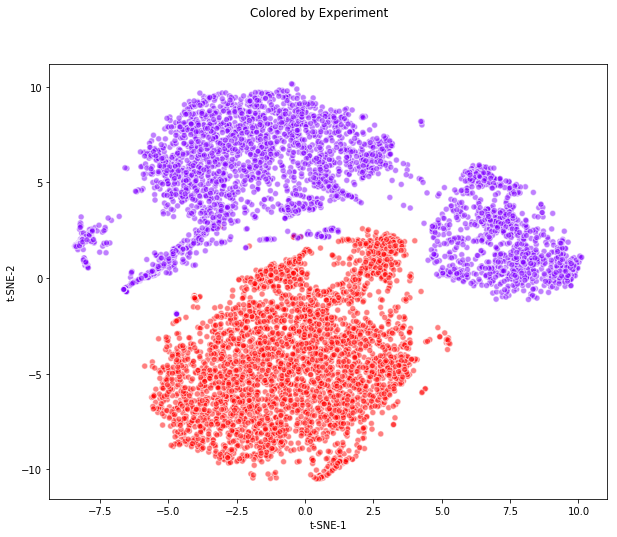

In [20]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Colored by Experiment')

# create color indexing for experiments
experiments = metadata['experiment']
keys = experiments.unique()
values = range(len(experiments))
replacementValues = {keys[i]: values[i] for i in range(len(keys))} 
experimentIndex = experiments.replace(replacementValues)

# create 2D plot
plt.scatter(projections['tSNE-1'], projections['tSNE-2'],
            c = experimentIndex, edgecolor='white', alpha=0.5,
            cmap = plt.cm.get_cmap('rainbow_r', 10))
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.show()

We can see that the EMPTY wells from two experiments seperate into two distinct clusters. It also appears that experiment 'HUVEC-2' seperates into two clusters.

<font size="4">Visualize t-SNE in 2D plot, colored by plate</font>

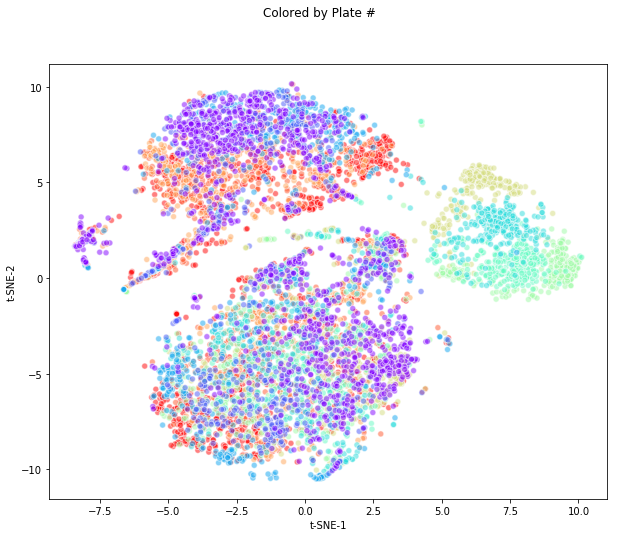

In [21]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Colored by Plate #')
# create 2D plot
plt.scatter(projections['tSNE-1'], projections['tSNE-2'],
            c = metadata.plate, edgecolor='white', alpha=0.5,
            cmap = plt.cm.get_cmap('rainbow_r', 10))
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.show()

Knowing the clusters seperated by experiment, this coloration shows that there are a few plates from the 'HUVEC-2' experiment that cluster away from the remaining plates of that experiment. This could indicate a potenial batch effect between the empty wells from these plates and the remaining plates from the experiment.

<font size="4">Visualize t-SNE in 2D plot, colored by well</font>

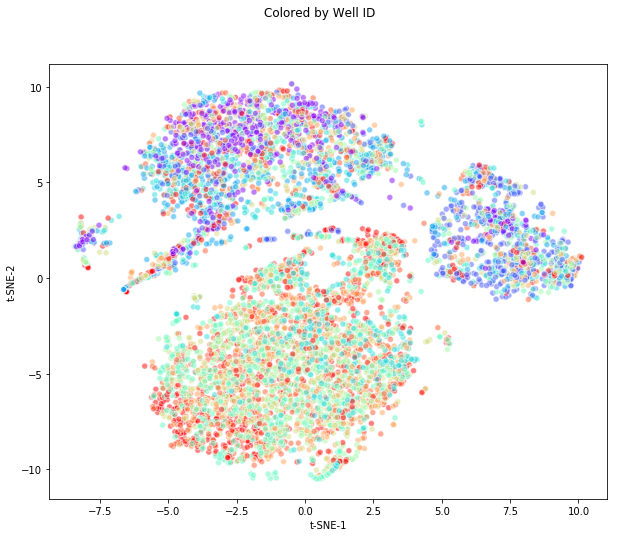

In [22]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Colored by Well ID')

# create color indexing for wells
wells = metadata['well']
keys = wells.unique()
values = range(len(wells))
replacementValues = {keys[i]: values[i] for i in range(len(keys))} 
wellIndex = wells.replace(replacementValues)

# create 2D plot
plt.scatter(projections['tSNE-1'], projections['tSNE-2'],
            c = wellIndex, edgecolor='white', alpha=0.5,
            cmap = plt.cm.get_cmap('rainbow_r', 10))
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.show()

<font size="4">Visualize t-SNE in 2D plot, colored by image site</font>

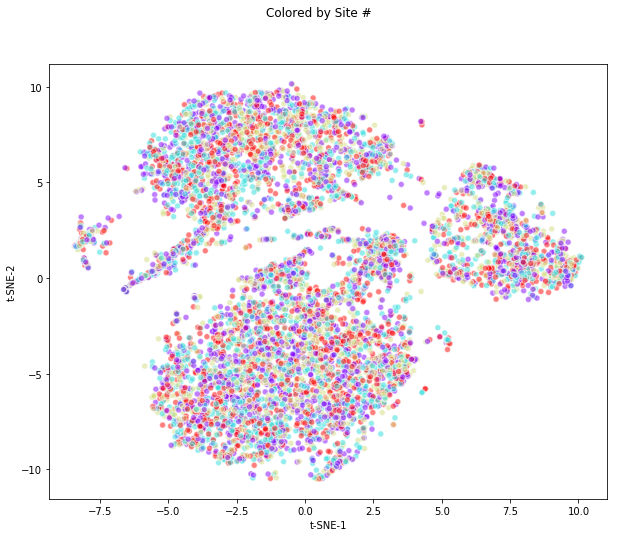

In [23]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Colored by Site #')

# create 2D plot
plt.scatter(projections['tSNE-1'], projections['tSNE-2'],
            c = metadata.site, edgecolor='white', alpha=0.5,
            cmap = plt.cm.get_cmap('rainbow_r', 10))
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.show()

### Summary:

Looking at Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE), we are able to distiguish clustering between the experiments within the image embeddings. Using t-SNE we were able to observe several plates that cluster away from the remaining plates from a given experiment. And we were also able to observe no clear clustering between wells or image site locations.

Next steps could include analyzing treated wells to highlight clusters of treatments forming away from EMPTY wells, indicating perturbation caused by treatments.